In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from joblib import Parallel, delayed
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical



preprocessed_df = pd.read_csv('/content/drive/MyDrive/DDos_dataset.csv')
preprocessed_df.size

28898436

In [ ]:
def z_score(df):
  df_std = df.copy()
  for column in df_std.columns:
    if df_std[column].std() != 0:
      df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
    else:
      df_std[column] = 0
  return df_std

def preprocess_data(data):
  normalized_df = z_score(data.loc[:, data.columns != ' Label'])
  normalized_df[' Label'] = data[' Label']

  train_df, test_df = train_test_split(normalized_df, test_size=0.15, shuffle=True)
  temp = train_df.loc[:, train_df.columns != ' Label']
  X_train = temp.to_numpy()
  y_train = train_df[' Label'].to_numpy()
  temp = test_df.loc[:, test_df.columns != ' Label']
  X_test = temp.to_numpy()
  y_test = test_df[' Label'].to_numpy()
  return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess_data(preprocessed_df)
X_train.size

24202410

In [ ]:
from sklearn.ensemble import StackingClassifier

rfc = RandomForestClassifier(n_estimators=100)
svm = SVC(kernel='rbf', C=1, decision_function_shape='ovr')
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
knn = KNeighborsClassifier(n_neighbors = 30)

estimators = [
    ('knn', knn),
    ('rfc', rfc),
    ('svm', svm),
    ('gbm', gbm)
]

# Define the meta model
meta_estimator = LogisticRegression(random_state=42)

# Create the stacking classifier
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=meta_estimator)
# Fit the stacking classifier on the training data
stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)




/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
import pickle

with open('/content/drive/MyDrive/ensemble_model.pkl', 'wb') as file:
    pickle.dump(stacking_clf, file)

# # using pickle
# with open('ensemble_model.pkl', 'rb') as file:
#     model = pickle.load(file)

Accuracy: 0.8737352345992753
Precision:  0.8822124200310004
Recall:  0.8737352345992753
F1-score:  0.8623658772192967
Confusion Matrix:


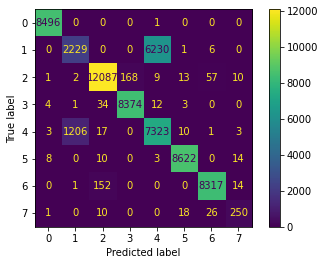

In [ ]:
# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the metrics to the console
print("Accuracy:", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

# Get the confusion matrix for the model
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_dis = ConfusionMatrixDisplay.from_estimator(stacking_clf, X_test, y_test)

print("Confusion Matrix:")
print(conf_matrix_dis)

In [ ]:
!pip install shap

In [ ]:
import shap

explainer = shap.TreeExplainer(stacking_clf)
shap_values = explainer.shap_values(X_test)
mean_absolute_shap_values = np.abs(shap_values).mean(axis=0)
top_features_indices = np.argsort(-mean_absolute_shap_values)[:10] # select the top 10 features
top_features = X_train.columns[top_features_indices]

print(top_features)